## What is a Win Probability Model?

In our tutorial here a win probability model is a model that predicts which team will win the game at each minute (or whatever other increment you choose) throughout a game. You may have seen graphs that look like this as the output of one of these models.

![](fig1.png)

This exact example is taken from [Mike Beuoy's](https://twitter.com/inpredict) website [www.inpredictable.com](https://www.inpredictable.com/). He is more or less the main and best win probability guy in the game. If you don't follow Mike or read his excellent website, you should. What we're going to do is a very simple version of what you see on that site, and will produce a chart like the above as a final product. Let's get into it.

## Data

We're keeping it simple and just using play-by-play data to conduct our modeling. More effective models use pregame point spreads, team ratings, various and complex home court and travel adjustments, etc. We're going lukewarm tap water here and sticking to the basics.

1) pbp.parquet - simply a somewhat pre-cleaned play by play file from the 2018-19 season, the last before COVID-19 impacts. We went with parquet because these pbp files are big, and parquet compresses them down a bit for easy read in and uploading. Sidenote, go get vaccinated if you can/are able so I can go see an NBA game in person next season. 

## Step 1: Format the data how we want it and decide what's going into the model

One of the most important parts of this (or any) model is deciding what variables we think are important for predicting if a team wins a game given the current game situation. Since we want a probability as out outcome, we'll be using a binary classifier which returns a probability of win between 0-1. To build the model though, the two obvious ones are scoring margin and time remaining on the clock. Also, let's include the actual score as a three point margin in a 130-133 game is a little less meaningful than in a 75-78 game. This is also a proxy for pace if you think about it. Next we should also make sure to separate based on home and away. If it's good enough for Vegas, we need it. Also, let's try and add cumulative fouls in as well. Maybe identifying the bonus or too many players in foul trouble will help out model.

We're just simply doing some cumulative sums across scoring to get out variables, and making sure that fouls are assigned to the proper team. Also flipping the game time because the guy who scraped this data (me) is a dumb dumb. 

When you're starting out, resist the urge as [Senthil Natarajan](https://twitter.com/SENTH1S) says to "[dump] 25 features into a cauldron, [chant] 'XGBoost' three times and [wave] our magic wand". We will be dumping fewer features into our models and using LightGBM (I'm a LightGBM fanboy mostly because it's the first GBDT I ever used). 

Quick note here. You'll see that I've done more or less everything for the data prep in method chaining. This is a) not the only way to do this b) not an endorsement of this being the best (or even optimal) way to do this. I think it helps with R <-> Python translation for newcomers to both languages as it mimics the feel of the tidyverse style syntax that I wrote in R first. Also I think it looks neat.

In [83]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

pbp = pd.read_parquet("data/pbp.parquet")

pbp = (pbp
        .dropna(subset = ['nameTeam', 'eventGeneral'])
        .fillna(0)
        .assign(home_points_scored = lambda x: np.where(x.nameTeam == x.homeTeam, x.shotResultPoints, 0))
        .assign(away_points_scored = lambda x: np.where(x.nameTeam == x.awayTeam, x.shotResultPoints, 0))
        .assign(foul = lambda x: ["foul" in event for event in x.eventType])
        .assign(home_foul = lambda x: np.where((x.nameTeam == x.homeTeam) & (x.foul == True), 1, 0))
        .assign(away_foul = lambda x: np.where((x.nameTeam == x.awayTeam) & (x.foul == True), 1, 0))
        .assign(time_remaining = lambda x: 2880 - x.gametime)
        .assign(home_score = lambda x: x.groupby(['idGame'])['home_points_scored'].cumsum())
        .assign(away_score = lambda x: x.groupby(['idGame'])['away_points_scored'].cumsum())
        .assign(home_foul_totals = lambda x: x.groupby(['idGame'])['home_foul'].cumsum())
        .assign(away_foul_totals = lambda x: x.groupby(['idGame'])['away_foul'].cumsum())
        .assign(home_margin = lambda x: x.home_score - x.away_score)
       )

winner_frame = (pbp
                .groupby('idGame')[['home_score', 'away_score']]
                .max()
                .reset_index()
                .assign(home_win = lambda x: np.where(x.home_score > x.away_score, 1, 0))
                .drop(['home_score', 'away_score'], axis=1))

pbp = pbp.merge(winner_frame, how = "left", on = "idGame")
pbp = pbp[["idGame", "time_remaining", "home_score", "away_score", "home_margin", 
         "home_foul_totals", "away_foul_totals", "home_win"]]

pbp.drop(['idGame'], axis=1).head(10)

,time_remaining,home_score,away_score,home_margin,home_foul_totals,away_foul_totals,home_win
0,2860.0,0.0,0.0,0.0,0,0,1
1,2860.0,0.0,0.0,0.0,0,0,1
2,2835.0,0.0,0.0,0.0,0,0,1
3,2833.0,0.0,0.0,0.0,0,0,1
4,2828.0,0.0,0.0,0.0,0,0,1
5,2823.0,0.0,0.0,0.0,0,0,1
6,2818.0,0.0,0.0,0.0,0,0,1
7,2815.0,0.0,2.0,-2.0,0,0,1
8,2796.0,0.0,2.0,-2.0,0,0,1
9,2795.0,0.0,2.0,-2.0,0,0,1


## Step 2: Let's model the thing

So with our data setup the way we want, we need to do a quick review on how we're going to model this. The `home_win` column is our target variable, or what we're trying to predict. Everything else besides `idGame` is going to go into the model. Nice and easy. 

### Logistic Regression

The first thing we're going to try is a [logistic regression](https://stats.idre.ucla.edu/r/dae/logit-regression/) that takes our input data and returns a probability of `home_win`. If you're new to Python or modeling in general, master this section before moving onto the next. I promise you it's worth your time. 

### Step 1: Split the data and build the model

Our very first step is to split our data into training and testing. This should *not* be done randomly, but on the game level. We want all the games in train to only be in train and all the games in test to only be in test. Otherwise you get serious leakage issues. Note, we're removing `home_margin` from this model because otherwise it'll throw a warning and give us NA's due to the presence of `home_score` and `away_score` resulting in the same value.

In [84]:
games = np.unique(pbp["idGame"]) ## get all the unique games (there are 500 of them)
train_games = np.random.choice(games, size=400, replace=False)
train = pbp.loc[pbp['idGame'].isin(train_games)]
test = pbp.loc[~pbp['idGame'].isin(train_games)]

Brief interlude. I'm going to use `statsmodels` here instead of `sklearn` for the logistic regression. I prefer `statsmodels` for "traditional statistical models", as there is a nice summary table like R's `summary(model)`. 

In [85]:
import statsmodels.api as sm

features = ['time_remaining', 'home_score', 'away_score', 'home_foul_totals', 'away_foul_totals']
target = ['home_win']

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

model = sm.Logit(y_train, X_train).fit() ### THE y, x ORDER HERE IS DIFFERENT FROM SKLEARN SYNTAX
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.491855
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               home_win   No. Observations:               160564
Model:                          Logit   Df Residuals:                   160559
Method:                           MLE   Df Model:                            4
Date:                Mon, 05 Apr 2021   Pseudo R-squ.:                  0.2741
Time:                        15:09:11   Log-Likelihood:                -78974.
converged:                       True   LL-Null:                   -1.0880e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
time_remaining       0.0001   4.04e-06     34.069      0.000       0.000       0.000
home_score 

Those coefficients all look sensible and square with what we know about basketball. Now, let's see how our model does from a prediction standpoint.

### Step 2: Evaluate the model

We're going to use pure accuracy here where if Pr(home_win) > 0.5 and home_win == 1, then the prediction is correct. However, this is probably not the best metric and you should look into log-loss and/or Brier score as alternatives/supplements. 

In [86]:
from sklearn.metrics import accuracy_score

train_predictions = model.predict(X_train)
train_predictions_01 = 1 * (train_predictions > 0.50)

test_predictions = model.predict(X_test)
test_predictions_01 = 1 * (test_predictions > 0.50)

print(f"Training Accuracy %: {round(100 * accuracy_score(y_train, train_predictions_01), 1)}")
print(f"Testing Accuracy %: {round(100 * accuracy_score(y_test, test_predictions_01), 1)}")
print(f"The chance of a home team winning a game at tip is {round(100 * train_predictions[0], 1)} %")


Training Accuracy %: 75.1
Testing Accuracy %: 75.2
The chance of a home team winning a game at tip is 59.7 %


Not bad! We'll leave that model alone for now and move along. However, something important to note is that if we look at the first prediction of any game, we can determine what the home court advantage is. If it's greater than 50% (which ours is at ~60 percent), that's the home team, and less than 50% it's the away team. Keep in mind that's only possible because there is no team-specific information contained in this model.

### LightGBM

Now let's learn some machines using [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html), one of the gold standard gradient boosting tree libraries. We're going to broadly speaking repeat the same process as before. We split our data into train and test, and then  build our model and evaluate it. There's quite a bit more code here since the process for LightGBM is a bit more complex. Keep in mind that this is not an endorsement that LightGBM is automatically better than logistic regression. It's far easier to make a garbage model with machine learning if you're not careful. The upside is that we can probably get some more predictive power, although our intentionally simplified feature space will likely put a damper on that.

### Step 1: Split the data and decide on cross validation

We split the data more or less the same as we did with out previous model, just a few formatting steps to get the datasets into the proper type for LightGBM. Since we're going to be CV'ing our model, we need to decide carefully how to do that. Just as when we made sure that all games in train and test are distinct, we need to do that as well for our CV folds. No game should be trained on and the tested on in the CV or the overall evaluation. We use `sklearn.model_selection.GroupKFold()` to create indices on the game level. If this doesn't quite make sense, take some time and line by line it. The vast majority of the work for machine learning (non-deep learning edition) is properly setting up validation and evaluation methods, not coding the actual models.

In [87]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, train_test_split
import scipy as sp

X_train = train[features]
y_train = train[target].to_numpy().flatten() ## removes column vector shape
group_train = train['idGame']

X_train, X_val, y_train, y_val, group_train, group_val = train_test_split(X_train, y_train, group_train, test_size = 0.10, random_state = 2020)

X_test = test[features]
y_test = test[target].to_numpy().flatten()

group_kfold = GroupKFold(n_splits = 5).split(X_train, y_train, group_train)    


### Step 2: Tuning

With the splits and groups defined, we move onto the tuning of the hyperparameters of the model. Hyperparameters essentially control how the model learns. LightGBM comes with solid default values, but let's give a quick tune anyway. Our first step is to define the grid of values which we want to use. This grid has some non-extreme values given that we have a model that is pretty small in terms of predictors. `sklearn.model_selection.RandomSearchCV()` takes care of the tuning and cross validation across a random walk of the parameters. It's a pretty good way to do it, although there are more complex parameter search methods available such as Optuna and Ray Tune.

In [ ]:
lgb = LGBMClassifier(random_state = 2020, n_estimators = 1000)

param_grid = { 
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [0.01, 0.05, 1, 10, 20, 100],
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=10)),
    'subsample': [0.2, 0.4, 0.6, 0.8], 
    'colsample_bytree': [0.4, 0.5, 0.6]
    }

fit_params = {
    "early_stopping_rounds": 5, 
    "eval_set": [(X_val, y_val)],
    'eval_names': ['Validation Set'],
    'eval_metric': ['binary'],
    'verbose': 100,
    'groups': group_train
    }

rand_search = RandomizedSearchCV(
    estimator = lgb, 
    param_distributions = param_grid, 
    n_iter = 10,
    cv = group_kfold,         
    random_state = 2020,
    n_jobs = 8) ## adjust this for y

### Step 3: The actual tuning/modeling

In [88]:
rand_search.fit(X_train, y_train, **fit_params)    
best_model = rand_search.best_estimator_

Training until validation scores don't improve for 5 rounds
[100]	Validation Set's binary_logloss: 0.567388
[200]	Validation Set's binary_logloss: 0.528313
[300]	Validation Set's binary_logloss: 0.505711
[400]	Validation Set's binary_logloss: 0.490945
[500]	Validation Set's binary_logloss: 0.481046
[600]	Validation Set's binary_logloss: 0.474172
[700]	Validation Set's binary_logloss: 0.468371
[800]	Validation Set's binary_logloss: 0.464571
[900]	Validation Set's binary_logloss: 0.461638
[1000]	Validation Set's binary_logloss: 0.459296
Did not meet early stopping. Best iteration is:
[1000]	Validation Set's binary_logloss: 0.459296



### Step 4: Evaluate

With the tuned best model (`best_model`), we now can predict on our training and test data to see how we did.

In [89]:
train_predictions_01 = best_model.predict(X_train)
test_predictions_01 = best_model.predict(X_test)
test_predictions = best_model.predict_proba(X_test)[:, 1]

print(f"Training Accuracy %: {round(100 * accuracy_score(y_train, train_predictions_01), 1)}")
print(f"Testing Accuracy %: {round(100 * accuracy_score(y_test, test_predictions_01), 1)}")

Training Accuracy %: 77.1
Testing Accuracy %: 74.0


Tiny overfit perhaps?

### Step 5: Make a janky chart

If it's not obvious, my charting skills in python are several ordes of magnitude worse than my R charting skills. If this is crap code, please let me know.

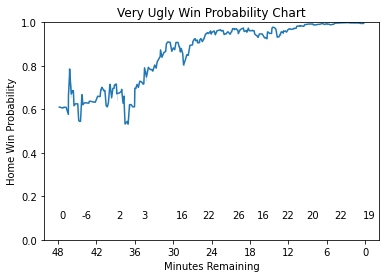

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt 

test['home_win_prob'] = test_predictions
random_game = test['idGame'].values[0]
plot_data = test.loc[test["idGame"] == random_game]
plot_data['minutes_remaining'] = plot_data['time_remaining']/60
label_frame = plot_data.iloc[np.arange(0, len(plot_data), 40)]
label_frame = label_frame[['home_margin', 'minutes_remaining']]

## I have no real idea what I'm doing here
plot = sns.lineplot(x=plot_data['minutes_remaining'], 
                    y=plot_data['home_win_prob'])
plot.invert_xaxis()
plot.set(ylim=(0, 1))
plot.set_xticks([48, 42, 36, 30, 24, 18, 12, 6, 0])
plot.set_title("Very Ugly Win Probability Chart")
plot.set_ylabel("Home Win Probability")
plot.set_xlabel("Minutes Remaining")
for idx in range(len(label_frame)):
    plot.annotate(f"{int(label_frame['home_margin'].values[idx])}", xy=(label_frame['minutes_remaining'].values[idx], 0.1))
plt.show()


There you go. Statistical and ML approaches to making a win probability model. Couple things to consider 1) our model doesn't include *any* sample weighting, and you should think about the best ways to implement that 2) this is not a best practices article on model building. We didn't look at calibration, errors by quarter, score, etc. Lots of things to improve on, but this is a super bare bones starting point. Good luck.

Side note, based on ye olde eyeball test, this model appears far better calibrated than the one we did in R. I'm skeptical of my tuning in R in that case maybe?